# Hamiltonian Monte Carlo

Having introduced first-generation MCMC methods previously, we will now turn our attention to a more sophisticated class of algorithm, which improve upon random-walk jump algorithms by using information about the posterior distribution to inform candidate transitions: namely, gradient information.

While flexible and easy to implement, Metropolis-Hastings sampling is a random walk
sampler that might not be statistically efficient for many models. Specifically, for models of high dimension, random walk jumping algorithms do not perform well. It is not enough to simply guess at the next sample location; we need to make each iteration a useful draw from the posterior whenever we can, in order to have an efficient sampler for bigger models.

Since Bayesian inference is all about calculating expectations over posteriors, what we seek is an algorithm that explores the area of the parameter space that contains most of the non-zero probability. This region is called the **typical set**.



### What's a Typical Set?

The typical set is where most of the probability density (mass) lies in a particular volume associated with the distribution. As the dimension of a model increases, this set moves progressively further from the mode, and becomes more singular, as the result of concentration of measure.

The typical set is a product of both the density, which is highest at the mode, and volume (that we integrate over), which increasingly becomes larger away from the mode as dimensionality increases. In fact, at high dimensions, the region around the mode contributes almost nothing to the expectation. We need an algorithm that will find this narrow region and explore it efficiently.

![from Hoffman and Gelman 2014](http://d.pr/i/RAA+)

In this context, and when sampling from continuous variables, Hamiltonian (or Hybrid) Monte
Carlo (HMC) can prove to be a powerful tool. It avoids
random walk behavior by simulating a physical system governed by
Hamiltonian dynamics, potentially avoiding tricky conditional
distributions in the process.

In HMC, model samples are obtained by simulating a physical system,
where particles move about a high-dimensional landscape, subject to
potential and kinetic energies. Adapting the notation from [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html),
particles are characterized by a position vector or state
$s \in \mathcal{R}^D$ and velocity vector $\phi \in \mathcal{R}^D$. The
combined state of a particle is denoted as $\chi=(s,\phi)$. 

The joint **canonical distribution** of the position and velocity can be expressed as a product of the marginal position (which is of interest) and the conditional distribution of the velocity:

$$\pi(s, \phi) = \pi(\phi | s) \pi(s)$$

This joint probability can also be written in terms of an invariant **Hamiltonian function**:

$$\pi(s, \phi) \propto \exp(-H(s,\phi))$$

The Hamiltonian is then defined as the sum of potential energy $E(s)$ and kinetic energy
$K(\phi)$, as follows:

$$\mathcal{H}(s,\phi) = E(s) + K(\phi)
= E(s) + \frac{1}{2} \sum_i \phi_i^2$$

Instead of sampling $p(s)$ directly, HMC operates by sampling from the canonical distribution.

$$p(s,\phi) = \frac{1}{Z} \exp(-\mathcal{H}(s,\phi))=p(s)p(\phi)$$.

If we choose a momentum that is independent of position, marginalizing over $\phi$ is
trivial and recovers the original distribution of interest.

Note that the Hamiltonian $\mathcal{H}$ is independent of the parameterization of the model, and therefore, captures the geometry of the phase space distribution, including typical set. 

**Hamiltonian Dynamics**

State $s$ and velocity $\phi$ are modified such that
$\mathcal{H}(s,\phi)$ remains constant throughout the simulation. The
differential equations are given by:

$$\begin{aligned}\frac{ds_i}{dt} &= \frac{\partial \mathcal{H}}{\partial \phi_i} = \phi_i \\
\frac{d\phi_i}{dt} &= - \frac{\partial \mathcal{H}}{\partial s_i}
= - \frac{\partial E}{\partial s_i}
\end{aligned}$$

As shown in [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html), 
the above transformation preserves volume and is
reversible. The above dynamics can thus be used as transition operators
of a Markov chain and will leave $p(s,\phi)$ invariant. That chain by
itself is not ergodic however, since simulating the dynamics maintains a
fixed Hamiltonian $\mathcal{H}(s,\phi)$. HMC thus alternates Hamiltonian
dynamic steps, with Gibbs sampling of the velocity. Because $p(s)$ and
$p(\phi)$ are independent, sampling $\phi_{new} \sim p(\phi|s)$ is
trivial since $p(\phi|s)=p(\phi)$, where $p(\phi)$ is often taken to be
the univariate Gaussian.

**The Leap-Frog Algorithm**

In practice, we cannot simulate Hamiltonian dynamics exactly because of
the problem of time discretization. There are several ways one can do
this. To maintain invariance of the Markov chain however, care must be
taken to preserve the properties of *volume conservation* and *time
reversibility*. The **leap-frog algorithm** maintains these properties
and operates in 3 steps:

$$\begin{aligned}
\phi_i(t + \epsilon/2) &= \phi_i(t) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\phi_i(t + \epsilon) &= \phi_i(t + \epsilon/2) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + \epsilon)) 
\end{aligned}$$

We thus perform a half-step update of the velocity at time
$t+\epsilon/2$, which is then used to compute $s(t + \epsilon)$ and
$\phi(t + \epsilon)$.

**Accept / Reject**

In practice, using finite stepsizes $\epsilon$ will not preserve
$\mathcal{H}(s,\phi)$ exactly and will introduce bias in the simulation.
Also, rounding errors due to the use of floating point numbers means
that the above transformation will not be perfectly reversible.

HMC cancels these effects **exactly** by adding a Metropolis
accept/reject stage, after $n$ leapfrog steps. The new state
$\chi' = (s',\phi')$ is accepted with probability $p_{acc}(\chi,\chi')$,
defined as:

$$p_{acc}(\chi,\chi') = min \left( 1, \frac{\exp(-\mathcal{H}(s',\phi')}{\exp(-\mathcal{H}(s,\phi)} \right)$$

**HMC Algorithm**

We obtain a new HMC sample as follows:

1.  sample a new velocity from a univariate Gaussian distribution
2.  perform $n$ leapfrog steps to obtain the new state $\chi'$
3.  perform accept/reject move of $\chi'$

Implementing HMC Using Theano
-----------------------------

In Theano, update dictionaries and shared variables provide a natural
way to implement a sampling algorithm. The current state of the sampler
can be represented as a Theano shared variable, with HMC updates being
implemented by the updates list of a Theano function.

We breakdown the HMC algorithm into the following sub-components:

-   `simulate_dynamics`: a symbolic Python function which, given an
    initial position and velocity, will perform `n_steps` leapfrog
    updates and return the symbolic variables for the proposed state
    $\chi'$.
-   `hmc_move`: a symbolic Python function which given a starting
    position, generates $\chi$ by randomly sampling a velocity vector.
    It then calls `simulate_dynamics` and determines whether the
    transition $\chi
    \rightarrow \chi'$ is to be accepted.
-   `hmc_updates`: a Python function which, given the symbolic
    outputs of `hmc_move`, generates the list of updates for a single
    iteration of HMC.
-   `HMC_sampler`: a Python helper class which wraps everything
    together.

**simulate\_dynamics**

To perform $n$ leapfrog steps, we first need to define a function over
which the algorithm can iterate. Instead of implementing leap frog verbatim, notice that we can obtain
$s(t + n \epsilon)$ and $\phi(t + n \epsilon)$ by performing an initial
half-step update for $\phi$, followed by $n$ full-step updates for
$s,\phi$ and one last half-step update for $\phi$. In loop form, this
gives:

$$\begin{aligned}\phi_i(t + \epsilon/2) &= \phi_i(t) -
\frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\text{For } m \in [2,n]\text{, perform full updates: } \\
\qquad
\phi_i(t + (m - 1/2)\epsilon) &= \phi_i(t + (m-3/2)\epsilon) -
\epsilon \frac{\partial{}}{\partial s_i} E(s(t + (m-1)\epsilon)) \\
\qquad
s_i(t + m\epsilon) &= s_i(t) + \epsilon \phi_i(t + (m-1/2)\epsilon) \\
\phi_i(t + n\epsilon) &= \phi_i(t + (n-1/2)\epsilon) -
\frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + n\epsilon)) 
\end{aligned}$$

The inner-loop defined above is implemented by the following
`leapfrog` function, with `pos`, `vel` and `step` replacing
$s,\phi$ and $\epsilon$ respectively.

```python
def leapfrog(pos, vel, step):

    # one full velocity step
    dE_dpos = tt.grad(energy_fn(pos).sum(), pos)
    new_vel = vel - step * dE_dpos
    
    # one full position step
    new_pos = pos + step * new_vel

    return [new_pos, new_vel],{}
```

The `simulate_dynamics` function performs the full algorithm. We start with the initial half-step update of $\phi$
and full-step of $s$, and then scan over the `leapfrog` method `n_steps-1` times.

In [44]:
def simulate_dynamics(initial_pos, initial_vel, stepsize, n_steps, energy_fn):
    

    def leapfrog(pos, vel, step):

        # Gradient calculation
        dE_dpos = tt.grad(energy_fn(pos).sum(), pos)
        
        new_vel = vel - step * dE_dpos
        new_pos = pos + step * new_vel
        return [new_pos, new_vel], {}

    # An initial half-step in velocity
    initial_energy = energy_fn(initial_pos)
    dE_dpos = tt.grad(initial_energy.sum(), initial_pos)
    vel_half_step = initial_vel - 0.5 * stepsize * dE_dpos

    # ... followed by one full position step
    pos_full_step = initial_pos + stepsize * vel_half_step

    # Perform full velocity-step updates afterwards, using scan
    (all_pos, all_vel), scan_updates = theano.scan(leapfrog,
            outputs_info=[
                dict(initial=pos_full_step),
                dict(initial=vel_half_step),
                ],
            non_sequences=[stepsize],
            n_steps=n_steps - 1)
    
    # Our final position after integrating
    final_pos = all_pos[-1]
    final_vel = all_vel[-1]
    
    # One final half-step in velocity to complete the algorithm
    energy = energy_fn(final_pos)
    final_vel = final_vel - 0.5 * stepsize * tt.grad(energy.sum(), final_pos)

    # return new proposal state
    return final_pos, final_vel

A final half-step is performed to compute $\phi(t+n\epsilon)$, and the
final proposed state $\chi'$ is returned.

**hmc_move**

The `hmc_move` function implements the remaining steps (steps 1 and
3) of an HMC move proposal (while wrapping the `simulate_dynamics`
function). Given a matrix of initial states
$s \in \mathcal{R}^{N \times D}$ (`positions`) and energy function
$E(s)$ (`energy_fn`), it defines the symbolic graph for computing
`n_steps` of HMC, using a given `stepsize`. The function prototype
is as follows:

In [45]:
def hmc_move(s_rng, positions, energy_fn, stepsize, n_steps):

    # sample random velocity using independent normals
    initial_vel = s_rng.normal(size=positions.shape)

    # perform simulation of particles subject to Hamiltonian dynamics
    final_pos, final_vel = simulate_dynamics(
            initial_pos=positions,
            initial_vel=initial_vel,
            stepsize=stepsize,
            n_steps=n_steps,
            energy_fn=energy_fn)

    # accept/reject the proposed move based on the joint distribution
    accept = metropolis_hastings_accept(
            energy_prev=hamiltonian(positions, initial_vel, energy_fn),
            energy_next=hamiltonian(final_pos, final_vel, energy_fn),
            s_rng=s_rng)

    return accept, final_pos

We start by sampling **random velocities**, using the provided shared
`RandomStream` object. Velocities are sampled independently for each
dimension and for each particle under simulation, yielding a
$N \times D$ matrix.

    initial_vel = s_rng.normal(size=positions.shape)
    
Since we now have an initial position and velocity, we can now call the
`simulate_dynamics` to obtain the proposal for the new state $\chi'$.

    final_pos, final_vel = simulate_dynamics(
            initial_pos = positions, 
            initial_vel = initial_vel,
            stepsize = stepsize,
            n_steps = n_steps,
            energy_fn = energy_fn)
            
We then **accept/reject** the proposed state based on the Metropolis
algorithm.

    accept = metropolis_hastings_accept(
            energy_prev=hamiltonian(positions, initial_vel, energy_fn),
            energy_next=hamiltonian(final_pos, final_vel, energy_fn),
            s_rng=s_rng)
            
where `metropolis_hastings_accept` and `hamiltonian` are helper
functions, defined as follows.

In [46]:
def metropolis_hastings_accept(energy_prev, energy_next, s_rng):
    
    ediff = energy_prev - energy_next
    return (tt.exp(ediff) - s_rng.uniform(size=energy_prev.shape)) >= 0


def kinetic_energy(vel):
    
    return 0.5 * (vel ** 2).sum(axis=1)


def hamiltonian(pos, vel, energy_fn):
    """
    Returns the Hamiltonian (sum of potential and kinetic energy) for the given
    velocity and position. Assumes mass is 1.
    """
    return energy_fn(pos) + kinetic_energy(vel)

`hmc_move` finally returns the tuple `(accept, final_pos)`.
`accept` is a symbolic boolean variable indicating whether or not the
new state `final_pos` should be used or not.

**hmc_updates**

The purpose of `hmc_updates` is to generate the **list of updates** to
perform, whenever our HMC sampling function is called. `hmc_updates`
thus receives as parameters, a series of shared variables to update
(`positions`, `stepsize` and `avg_acceptance_rate`), and the
parameters required to compute their new state.

    def hmc_updates(positions, stepsize, avg_acceptance_rate, final_pos, 
            accept, target_acceptance_rate, stepsize_inc, stepsize_dec, 
            stepsize_min, stepsize_max, avg_acceptance_slowness):
    
    
        accept_matrix = accept.dimshuffle(0, *(('x',) * (final_pos.ndim - 1)))
        
        new_positions = tt.switch(accept_matrix, final_pos, positions)
        
Using the above code, the dictionary `{positions: new_positions}` can
be used to update the state of the sampler with either (1) the new state
`final_pos` if `accept` is True, or (2) the old state if `accept`
is False. This conditional assignment is performed by Theano's
[switch](http://deeplearning.net/software/theano/library/tensor/basic.html#tensor.switch)
function.

`switch` expects as its first argument, a boolean mask with the same
broadcastable dimensions as the second and third argument. Since
`accept` is scalar-valued, we must first use
[dimshuffle](http://deeplearning.net/software/theano/library/tensor/basic.html#tensor._tensor_py_operators.dimshuffle)
to permute the dimensions so that it is of the appropriate
dimensions for broadcasting.

`hmc_updates` additionally implements an *adaptive* version of HMC. We start by
tracking the average acceptance rate of the HMC move proposals (across
many simulations), using an exponential moving average with time
constant `1 - avg_acceptance_slowness`.

    new_acceptance_rate = tt.add(
            avg_acceptance_slowness * avg_acceptance_rate,
            (1.0 - avg_acceptance_slowness) * accept.mean())
            
If the average acceptance rate is larger than the
`target_acceptance_rate`, we increase the `stepsize` by a factor
of `stepsize_inc` in order to increase the mixing rate of our chain.
If the average acceptance rate is too low however, `stepsize` is
decreased by a factor of `stepsize_dec`, yielding a more conservative
mixing rate.

    _new_stepsize = tt.switch(avg_acceptance_rate > target_acceptance_rate,
                              stepsize * stepsize_inc, stepsize * stepsize_dec)

    new_stepsize = tt.clip(_new_stepsize, stepsize_min, stepsize_max)

The
[`clip`](http://deeplearning.net/software/theano/library/tensor/basic.html#tensor.clip)
function allows us to maintain the `stepsize` in the range
[`stepsize_min`, `stepsize_max`].

The final updates list is then returned:

    return [(positions, new_positions),
        (stepsize, new_stepsize),
        (avg_acceptance_rate, new_acceptance_rate)]

In [47]:
def hmc_updates(positions, stepsize, avg_acceptance_rate, final_pos, accept,
                 target_acceptance_rate, stepsize_inc, stepsize_dec,
                 stepsize_min, stepsize_max, avg_acceptance_slowness):

    """
    POSITION UPDATES
    
    Uses results of the acceptance test to update position
    """

    accept_matrix = accept.dimshuffle(0, *(('x',) * (final_pos.ndim - 1)))
    # if accept is True, update to `final_pos` else stay put
    new_positions = tt.switch(accept_matrix, final_pos, positions)

    """
    STEP SIZE UPDATES
    
    If the acceptance rate is two low, reduce the stepsize; if it is too high, 
    increase the stepsize
    """
    
    _new_stepsize = tt.switch(avg_acceptance_rate > target_acceptance_rate,
                              stepsize * stepsize_inc, stepsize * stepsize_dec)
    # maintain stepsize in [stepsize_min, stepsize_max]
    new_stepsize = tt.clip(_new_stepsize, stepsize_min, stepsize_max)

    # Update acceptance rate with exponential moving average
    mean_dtype = theano.scalar.upcast(accept.dtype, avg_acceptance_rate.dtype)
    new_acceptance_rate = tt.add(
            avg_acceptance_slowness * avg_acceptance_rate,
            (1.0 - avg_acceptance_slowness) * accept.mean(dtype=mean_dtype))

    return [(positions, new_positions),
            (stepsize, new_stepsize),
            (avg_acceptance_rate, new_acceptance_rate)]

**HMC_sampler**

We implement the sampler in a Python class, called `HMC_Sampler`. It is a convenience wrapper for performing Hybrid Monte Carlo (HMC). It creates the symbolic graph for performing an HMC simulation (using `hmc_move` and `hmc_updates`). The graph is then compiled into the `simulate` function, a theano function which runs the simulation and updates the required shared
variables. Its main attributes are:

-   `new_from_shared_positions`: a constructor method which
    allocates various shared variables and strings together the calls to
    `hmc_move` and `hmc_updates`. It also builds the theano
    function `simulate`, whose sole purpose is to execute the updates
    generated by `hmc_updates`.
-   `draw`: a convenience method which calls the Theano function
    `simulate` and returns a copy of the contents of the shared
    variable `self.positions`.

In [48]:
sharedX = lambda X, name: \
        shared(np.asarray(X, dtype=theano.config.floatX), name=name)

class HMC(object):

    def __init__(self, shared_positions, energy_fn,
            initial_stepsize=0.01, target_acceptance_rate=.9, n_steps=20,
            stepsize_dec=0.98,
            stepsize_min=0.001,
            stepsize_max=0.25,
            stepsize_inc=1.02,
            avg_acceptance_slowness=0.9,
            seed=12345):
        
        self.positions = shared_positions
        
        batchsize = shared_positions.shape[0]

        # allocate shared variables
        self.stepsize = stepsize = sharedX(initial_stepsize, 'hmc_stepsize')
        self.avg_acceptance_rate = avg_acceptance_rate = sharedX(target_acceptance_rate,
                                      'avg_acceptance_rate')
        
        s_rng = tt.shared_randomstreams.RandomStreams(seed)

        # define graph for an `n_steps` HMC simulation
        accept, final_pos = hmc_move(
                s_rng,
                shared_positions,
                energy_fn,
                stepsize,
                n_steps)

        # define the dictionary of updates, to apply on every `simulate` call
        simulate_updates = hmc_updates(
                shared_positions,
                stepsize,
                avg_acceptance_rate,
                final_pos=final_pos,
                accept=accept,
                stepsize_min=stepsize_min,
                stepsize_max=stepsize_max,
                stepsize_inc=stepsize_inc,
                stepsize_dec=stepsize_dec,
                target_acceptance_rate=target_acceptance_rate,
                avg_acceptance_slowness=avg_acceptance_slowness)

        # compile theano function
        self.simulate = function([], [], updates=simulate_updates)


    def draw(self, **kwargs):
        """
        Returns a new position obtained after `n_steps` of HMC simulation.
        """
        self.simulate()
        return self.positions.get_value(borrow=False)

### Testing our Sampler

We test our implementation of HMC by sampling from a multi-variate
Gaussian distribution. We start by generating a random mean vector
`mu` and covariance matrix `cov`, which allows us to define the
energy function of the corresponding Gaussian distribution:
`gaussian_energy`. We then initialize the state of the sampler by
allocating a `position` shared variable. It is passed to the
constructor of `HMC_sampler` along with our target energy function.

Following a burn-in period, we then generate a large number of samples
and compare the empirical mean and covariance matrix to their true
values.

In [49]:
# Simulation hyperparameters
burnin=2000
n_samples=1000
dim=5
batchsize=3

Let's set up the model: a multivariate normal distribution.

In [50]:
rng = np.random.RandomState(123)

# Define a covariance and mu for a gaussian
mu  = np.array(rng.rand(dim) * 10, dtype=theano.config.floatX)
cov = np.array(rng.rand(dim, dim), dtype=theano.config.floatX)
cov = (cov + cov.T) / 2.
cov[np.arange(dim), np.arange(dim)] = 1.0
cov_inv = np.linalg.inv(cov)

# Define energy function for a multi-variate Gaussian
def gaussian_energy(x):
    return 0.5 * (tt.dot((x - mu), cov_inv) * (x - mu)).sum(axis=1)

# Declared shared random variable for positions
position = shared(rng.randn(batchsize, dim).astype(theano.config.floatX))

Now, let's initialize our sampler:

In [51]:
sampler = HMC(position, gaussian_energy,
        initial_stepsize=1e-3, stepsize_max=0.5)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Execute some tuning samples, to be discarded.

In [52]:
burn_me = [sampler.draw() for r in range(burnin)]

Now draw `n_samples` for inference. This returns a tensor of dimension `(n_samples, batchsize, dim)`.

In [53]:
samples = np.asarray([sampler.draw() for r in range(n_samples)])

In [54]:
samples.shape

(1000, 3, 5)

In [55]:
flat_samples = samples.T.reshape(dim, -1).T

In [56]:
print('****** TARGET VALUES ******')
print('target mean:', mu)
print('target cov:\n', cov)

print('****** EMPIRICAL MEAN/COV USING HMC ******')
print('empirical mean: ', flat_samples.mean(axis=0))
print('empirical_cov:\n', np.cov(flat_samples.T))

print('****** HMC INTERNALS ******')
print('final stepsize', sampler.stepsize.get_value())
print('final acceptance_rate', sampler.avg_acceptance_rate.get_value())

****** TARGET VALUES ******
target mean: [6.96469186 2.86139335 2.26851454 5.51314769 7.1946897 ]
target cov:
 [[1.         0.66197111 0.71141257 0.55766643 0.35753822]
 [0.66197111 1.         0.31053199 0.45455485 0.37991646]
 [0.71141257 0.31053199 1.         0.62800335 0.38004541]
 [0.55766643 0.45455485 0.62800335 1.         0.50807871]
 [0.35753822 0.37991646 0.38004541 0.50807871 1.        ]]
****** EMPIRICAL MEAN/COV USING HMC ******
empirical mean:  [7.01443438 2.8979705  2.33591323 5.57346381 7.25733106]
empirical_cov:
 [[1.04033396 0.6721692  0.7756952  0.60719616 0.39925109]
 [0.6721692  1.03321239 0.34309513 0.48219892 0.42882713]
 [0.7756952  0.34309513 1.10562853 0.69613545 0.44126916]
 [0.60719616 0.48219892 0.69613545 1.07920969 0.55688503]
 [0.39925109 0.42882713 0.44126916 0.55688503 1.06562072]]
****** HMC INTERNALS ******
final stepsize 0.5
final acceptance_rate 0.9052926475589113


As can be seen above, the samples generated by our HMC sampler yield an
empirical mean and covariance matrix, which are very close to the true
underlying parameters. The adaptive algorithm also seemed to work well
as the final acceptance rate is close to our target of `0.9`.

## Non-centered Parameterization

The partial pooling models specified above uses a **centered** parameterization of the slope random effect. That is, the individual county effects are distributed around a county mean, with a spread controlled by the hierarchical standard deviation parameter. As the preceding plot reveals, this constraint serves to **shrink** county estimates toward the overall mean, to a degree proportional to the county sample size. This is exactly what we want, and the model appears to fit well--the Gelman-Rubin statistics are exactly 1.

But, on closer inspection, there are signs of trouble. Specifically, let's look at the trace of the random effects, and their corresponding standard deviation:

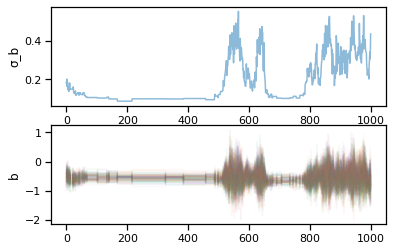

In [54]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_slope_trace.get_values('σ_b', chains=0), alpha=.5);
axs[0].set(ylabel='σ_b');
axs[1].plot(varying_slope_trace.get_values('b', chains=0), alpha=.05);
axs[1].set(ylabel='b');

Notice that when the chain reaches the lower end of the parameter space for $\sigma_b$, it appears to get "stuck" and the entire sampler, including the random slopes `b`, mixes poorly. 

Jointly plotting the random effect variance and one of the individual random slopes demonstrates what is going on.

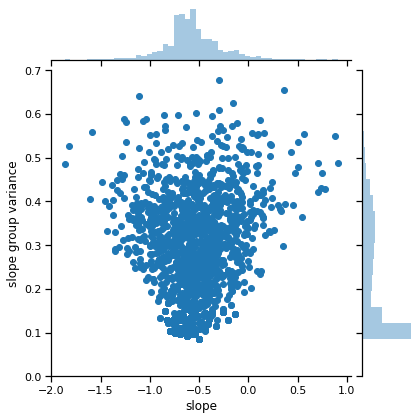

In [55]:
x = pd.Series(varying_slope_trace['b'][:, 10], name='slope')
y = pd.Series(varying_slope_trace['σ_b'], name='slope group variance')

jp = sns.jointplot(x, y, ylim=(0, .7), stat_func=None)

When the group variance is small, this implies that the individual random slopes are themselves close to the group mean. This results in a *funnel*-shaped relationship between the samples of group variance and any of the slopes (particularly those with a smaller sample size). 

In itself, this is not a problem, since this is the behavior we expect. However, if the sampler is tuned for the wider (unconstrained) part of the parameter space, it has trouble in the areas of higher curvature. The consequence of this is that the neighborhood close to the lower bound of $\sigma_b$ is sampled poorly; indeed, in our chain it is not sampled at all below 0.1. The result of this will be biased inference.

Now that we've spotted the problem, what can we do about it? The best way to deal with this issue is to reparameterize our model. Notice the random slopes in this version:

In [56]:
from pymc3 import Deterministic

with Model() as varying_slope_noncentered:
    
    # Priors
    μ_b = Normal('μ_b', mu=0., sigma=10)
    σ_b = HalfCauchy('σ_b', 5)
    
    # Common intercepts
    a = Normal('a', mu=0., sigma=10)
    
    # Non-centered random slopes
    # Centered: b = Normal('b', μ_b, sigma=σ_b, shape=counties)
    υ = Normal('υ', mu=0, sigma=1, shape=n_counties)
    b = Deterministic("b", μ_b + υ * σ_b)
    
    # Model error
    σ_y = HalfCauchy('σ_y',5)
    
    # Expected value
    y_hat = a + b[county] * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

This is a **non-centered** parameterization. By this, we mean that the random deviates are no longer explicitly modeled as being centered on $\mu_b$. Instead, they are independent standard normals $\upsilon$, which are then scaled by the appropriate value of $\sigma_b$, before being location-transformed by the mean.

This model samples much better.

In [57]:
with varying_slope_noncentered:
    noncentered_trace = sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_y, υ, a, σ_b, μ_b]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 16 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7133141376539398, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Notice that the bottlenecks in the traces are gone.

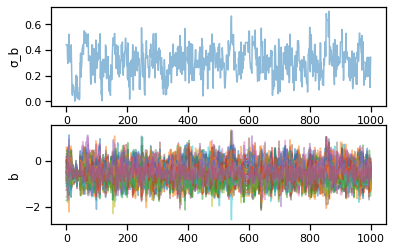

In [58]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(noncentered_trace.get_values('σ_b', chains=0), alpha=.5);
axs[0].set(ylabel='σ_b');
axs[1].plot(noncentered_trace.get_values('b', chains=0), alpha=.5);
axs[1].set(ylabel='b');

And, we are now fully exploring the support of the posterior.

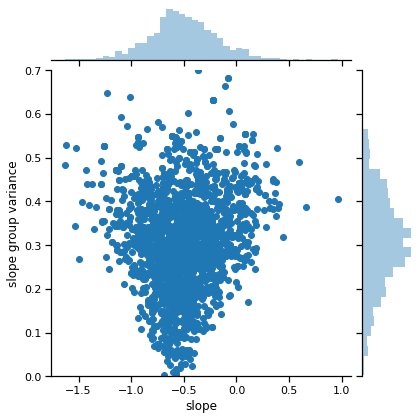

In [59]:
x = pd.Series(noncentered_trace['b'][:, 75], name='slope')
y = pd.Series(noncentered_trace['σ_b'], name='slope group variance')

sns.jointplot(x, y, ylim=(0, .7), stat_func=None);

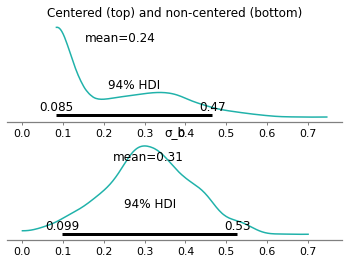

In [60]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plot_posterior(varying_slope_trace, var_names=['σ_b'], ax=ax1, color='LightSeaGreen')
plot_posterior(noncentered_trace, var_names=['σ_b'], ax=ax2, color='LightSeaGreen')
ax1.set_title('Centered (top) and non-centered (bottom)');

___
## References

1. Team TTD, Al-Rfou R, Alain G, et al. (2016) [Theano: A Python framework for fast computation of mathematical expressions](https://arxiv.org/abs/1605.02688). arXiv.org.
2. Neal, R. M. (2010) [MCMC using Hamiltonian dynamics](http://www.mcmchandbook.net/HandbookChapter5.pdf), in the Handbook of Markov Chain Monte Carlo, S. Brooks, A. Gelman, G. L. Jones, and X.-L. Meng (editors), Chapman & Hall / CRC Press, pp. 113-162.
3. Betancourt, M. (2017). [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434). arXiv.org.